# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., **use X[n-1] and X[n-2] to predict X[n]**.

In [2]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3]) # extra coordinate for bias
X_training[:,1] = norm_data[: m_training - 2] #X[n-2]
X_training[:,2] = norm_data[1 : m_training - 1] #X[n-1]
Y_training = norm_data[2 : m_training] #X[n]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [3]:
from scipy import linalg as la
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> np.ndarray:
    ## TODO: Run the LS algorithm without regularization
    X = X_matrix.T # every column corresponds now to a sample
    A = np.dot(X, X_matrix)
    b = np.dot(X, labels)
    w = la.solve(A, b)
    return w

def evaluate_model(x: np.ndarray, y: np.ndarray, coeff: np.ndarray):
    ## TODO: Return the average MSE for the set over which we evaluate
    xt = x.T
    mse = np.sum( (np.dot(coeff, xt) - y)**2 )/ xt.shape[1]
    return mse

In [4]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.354721539341


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$


**My comment** I am using Ridge regression with the objective function:

$$ \text{argmin}_{w \in \mathcal{R}^d}\, \left\{ \lambda \cdot ||\vec{w}||^2 + \frac{1}{m}\, \sum_{i=1}^{m}\, [ \langle w, x_i \rangle - y_i ]^2 \right\} $$

which is the same formula on the lecture slides and on the book. Instead, the professor, without noticing that, is here using the formula:


$$ \text{argmin}_{w \in \mathcal{R}^d}\, \left\{ \lambda \cdot ||\vec{w}||^2 + \, \sum_{i=1}^{m}\, [ \langle w, x_i \rangle - y_i ]^2 \right\} $$

The values of $\lambda$ suggested in the exercise are optimized for the latter! Since I don't want to switch, I need to scale the $\lambda$ vector by $\frac{1}{m}$ to get his results.

Actually, the formula used by the professor is better, because the $\lambda$ parameter does not scale with 

In [5]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> np.ndarray:
    ## TODO: Run the LS algorithm with regularization
    X = X_matrix.T # every column corresponds now to a sample
    A = np.dot(X, X_matrix)
    b = np.dot(X, labels)
    M =  lambda_par * X.shape[1] * np.eye(N= A.shape[0]) + A
    w = la.solve(M, b)
    return w


def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> np.ndarray:
    ## TODO: Perform K-fold cross-validation
    """
    This function assumes that the data X is passed as a matrix with nrows = nsamples, ncols = nfeatures
    """
    idxs = np.arange(0, X_training.shape[0])
    np.random.shuffle(idxs)
    idxs_folds = np.array_split(idxs, K)
    lambda_errors = []
    w_vec = []
    for lambda_par in lambda_vec:
        # First fit using the whole set (it is requested by the exercise)
        w_vec.append(regularized_least_squares(X_training, Y_training, lambda_par))
        # Now do the K-fold validation
        error = 0
        for k in range(K):
            X_validation_fold = X_training[idxs_folds[k], :]
            Y_validation_fold = Y_training[idxs_folds[k]]
            idxs_training_fold = np.array( list(set(idxs) - set(idxs_folds[k])) )
            X_training_fold = X_training[idxs_training_fold, :]
            Y_training_fold = Y_training[idxs_training_fold]
            w_fold = regularized_least_squares(X_training_fold, Y_training_fold, lambda_par)
            error += evaluate_model(X_validation_fold, Y_validation_fold, w_fold)
        error /= K
        lambda_errors.append(error)
    lambda_best = lambda_vec[np.argmin(lambda_errors)]
    w_best = regularized_least_squares(X_training, Y_training, lambda_best)
    return w_best, lambda_best, w_vec, lambda_errors


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_5689/488017515.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


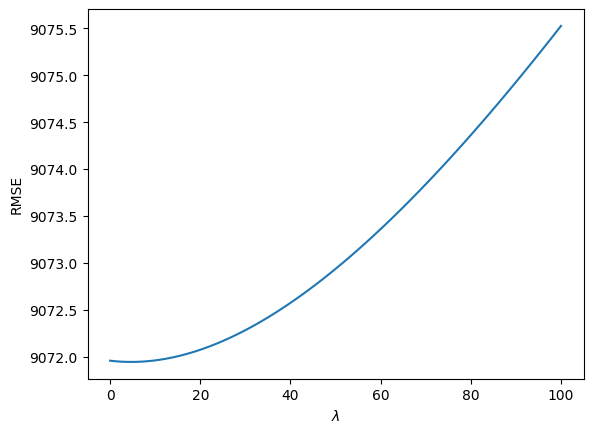

In [6]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = np.arange(0, 101)
lambda_par_normalized = lambda_par/X_training.shape[0]

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par_normalized, K)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_5689/1799133235.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


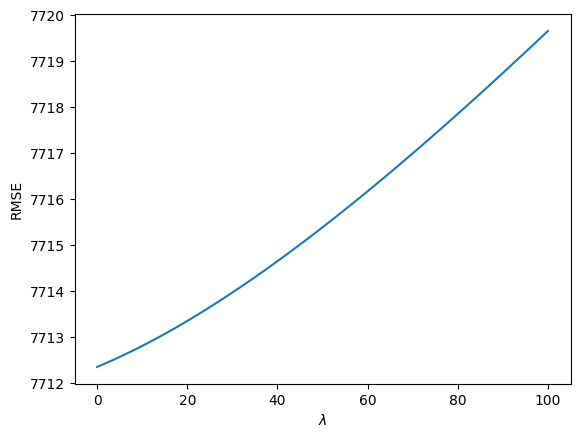

In [7]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


### EXTRA

Can you figure out the best amount of **memory** *(number of past frames)* to use *(in order to predict the next frame)* ?

*Solution:*

- *from a machine learning persective: perform another k-fold-cross-validation: increase number of samples (from $2$ to $3$, $4$ etc) to choose the best model, then test the performance on the test set.*

- *from another (I'd say smarter) perspective: plot the average autocorrelation function of the frame size $\mathbb{E}[F(t) \cdot F(t+ T)]$ versus the log $T$. If you see that it decays after $2$ frames, there is no point in considering more thant that.*

- *a perspective that encapsulates both: do the OSL (Ordinary Least Squares) regression for a different number of past frames, then plot the autocorrelation function of the residuals. If you see autocorrelation, it means that there is some pattern in your data that your regression model was not able to exploit. Instead if autocorrelations drops to zero very fast, you are ok.*

See the lecture recording for more.


## Why do we get a test loss that is lower than the training loss?

Generally, we would expect the test loss to be higher, as the model has not been trained on it. But it can be the opposite. 
It's instructive to investigate why this actually happens in our dataset.

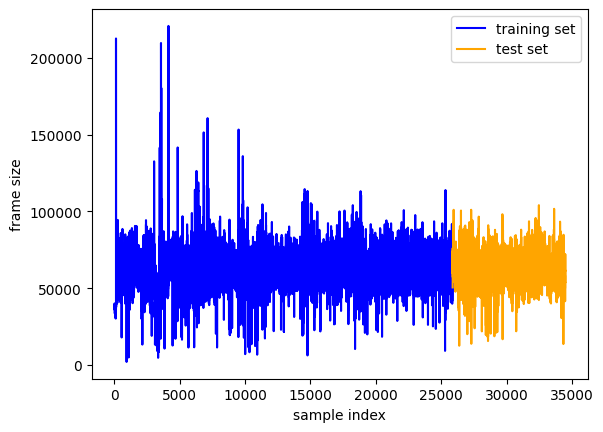

In [8]:
m_train = X_training.shape[0]
fig, axs = plt.subplots()
axs.plot(range(m_train), Y_training[:] * avg_size, color = 'blue', label = 'training set')
m = m_train + X_test.shape[0]
axs.plot(range(m_train, m), Y_test[:] * avg_size, color = 'orange', label= 'test set')
axs.set_xlabel('sample index')
axs.set_ylabel('frame size')
axs.legend(loc= 'best')

The reason why we get a lower error on the true set is because in the training set we have some very big outliers. The linear model does not accomodate for them, so their residuals also are big. Those contributions make the empirical risk evaluated on the training set higher than the empirical risk on the test set.

test loss:  0.015484801708150437
training loss:  0.021416036868421345


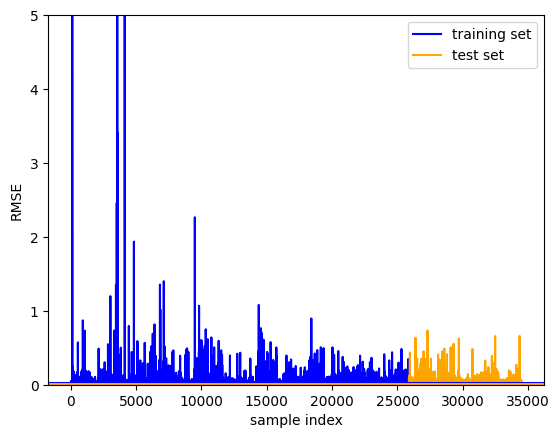

In [9]:
fig, axs = plt.subplots()
m_train = X_training.shape[0]
training_residuals = [(np.dot(X_training[i, :], best_model) - Y_training[i])**2 for i in range(m_train)] 
axs.plot(range(m_train), training_residuals, color = 'blue', label = 'training set')
m = m_train + X_test.shape[0]
test_residuals = [(np.dot(X_test[i, :], best_model) - Y_test[i])**2 for i in range(X_test.shape[0])] 

axs.plot(range(m_train, m),test_residuals, color = 'orange', label= 'test set')
axs.set_xlabel('sample index')
axs.set_ylabel('RMSE')
axs.set_ylim(bottom= 0, top=5)
axs.legend(loc= 'best')

test_loss = evaluate_model(X_test, Y_test, best_model) #mean mse
training_loss = evaluate_model(X_training, Y_training, best_model)

axs.axhline(y= training_loss, color = 'blue', label= 'training loss')
axs.axhline(y= test_loss, color = 'orange', label= 'test loss')
print("test loss: ", test_loss)
print("training loss: ", training_loss)